# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

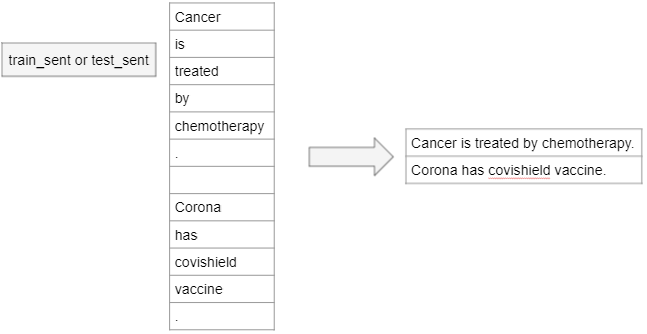

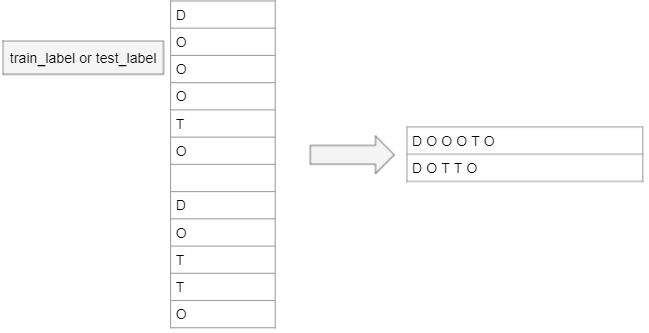

In [2]:
def make_lines(file_path):
    f=open(file_path,"r")
    f.seek(0)
    words=f.readlines()
    f.close()
    outlines=[]
    line = ""
    for word in words:
        word=word.strip()        
        if word == "" :
            #print("adding new line")
            outlines.append(line)
            line = ""
        else :
            if line=="":
                line=word
            else :
                line=line+" "+word
    return outlines
    
    

In [3]:
train_sentences=make_lines("train_sent")
train_labels=make_lines("train_label")
test_sentences=make_lines("test_sent")
test_labels=make_lines("test_label")

In [4]:
for i in range(5):
    print(train_sentences[i])

All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )


In [5]:
print(len(train_sentences))
print(len(train_labels))

2599
2599


### Count the number of sentences in the processed train and test dataset 

In [6]:
print(len(test_sentences))
print(len(test_sentences))

1056
1056


### Count the number of lines of labels in the processed train and test dataset.

In [7]:
print(len(train_labels))
print(len(test_labels))

2599
1056


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [8]:
concepts={}
for sentence in train_sentences:
    tokens=model(sentence)
    
    for token in tokens:
        #print(token.pos_)
        if token.pos_=="NOUN" or token.pos_=="PROPN":
            concepts[token.text]= concepts.get(token.text,0)+1
            #print(token.text,concepts[token.text])

In [9]:
print(concepts)

{'births': 1, 'weeks': 27, 'University': 6, 'Vermont': 1, 'delivery': 18, 'route': 2, 'indication': 3, 'cesarean': 2, 'age': 34, 'parity': 1, 'practice': 22, 'group': 63, 'risk': 49, 'status': 14, 'rate': 46, '%': 161, 'presentation': 6, 'fetal': 1, 'medicine': 29, 'patients': 354, 'Arrest': 1, 'dilation': 1, 'subgroups': 1, 'rates': 22, 'care': 47, 'hospitals': 8, 'community': 11, 'groups': 23, 'trimester': 4, 'index': 11, 'AFI': 3, 'temperature': 5, 'increases': 5, 'decrease': 3, 'June': 2, 'August': 5, 'period': 22, 'heat': 2, 'women': 48, 'singleton': 1, 'pregnancies': 7, 'gestation': 4, 'testing': 15, 'determinations': 2, 'area': 8, 'day': 27, 'mean': 1, 'test': 15, 'date': 2, 'Spearman': 1, 'rank': 1, 'Correlation': 3, 'relationship': 9, 'account': 4, 'measure': 3, 'being': 2, 'study': 103, 'population': 23, 'diabetes': 22, 'screening': 12, 'clinic': 4, 'Hadassah': 1, 'Medical': 5, 'Center': 3, 'year': 27, 'treatment': 195, 'week': 6, 'protocol': 5, 'control': 30, 'characteristic

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [10]:
from operator import itemgetter
res = dict(sorted(concepts.items(), key = itemgetter(1), reverse = True)[:25])
print(res)

{'patients': 354, 'treatment': 195, '%': 161, 'cancer': 135, 'therapy': 120, 'disease': 105, 'study': 103, 'cell': 99, 'lung': 87, 'chemotherapy': 65, 'group': 63, 'effects': 61, 'use': 54, 'gene': 54, 'results': 52, 'surgery': 51, 'survival': 50, 'dose': 50, 'risk': 49, 'women': 48, 'care': 47, 'analysis': 47, 'children': 47, 'activity': 47, 'rate': 46}


## Defining features for CRF





In [70]:
# Let's define the features to get the feature value for one word.

# Define a function to get the above defined features for a word.
# 'a place that serves soft serve ice cream \n'
def getFeaturesForOneWord(sentence, pos, pos_tags):
  #print(len(sentence))
  #print(pos)
  #print(len(pos_tags))
  word = sentence[pos]

  features = [
    'bias',
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'words.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'words.pos=' + pos_tags[pos],
    'words.pos[:2]=' + pos_tags[pos][:2],
    'words.isnoun=%s' % (pos_tags[pos] in ["NOUN","PROPN"])
    
  ]

  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(), 
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_words.startsWithCapital=%s' % prev_word[0].isupper(),
    'prev_words.pos=' + pos_tags[pos-1],
    #'prev_words.pos[:2]=' + pos_tags[pos-1][:2],
    'prev_words.isnoun=%s' % (pos_tags[pos-1] in ["NOUN","PROPN"])
  ])
  else:
    features.append('BEG') # feature to track begin of sentence 

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence

  return features


## Getting the features

### Write a code/function to get the features for a sentence

In [71]:
# Write a code to get features for a sentence.

# Define a function to get features for a sentence 
# using the 'getFeaturesForOneWord' function.

def getFeaturesForOneSentence(sentence):
  sentence_list=sentence.split()
  processed_sentence = model(sentence)
  pos_tags = [] # correctly identified POS tags
  for token in processed_sentence:
    pos_tags.append(token.pos_)
  return [getFeaturesForOneWord(sentence_list, pos, pos_tags) for pos in range(len(sentence_list))]


In [72]:
sentence_list=train_sentences[0].split()
sentence_list
len(sentence_list)

45

In [73]:
getFeaturesForOneSentence(train_sentences[0])

[['bias',
  'word.lower=all',
  'word[-3:]=All',
  'word[-2:]=ll',
  'word.isupper=False',
  'word.isdigit=False',
  'words.startsWithCapital=True',
  'words.pos=DET',
  'words.pos[:2]=DE',
  'words.isnoun=False',
  'BEG'],
 ['bias',
  'word.lower=live',
  'word[-3:]=ive',
  'word[-2:]=ve',
  'word.isupper=False',
  'word.isdigit=False',
  'words.startsWithCapital=False',
  'words.pos=ADJ',
  'words.pos[:2]=AD',
  'words.isnoun=False',
  'prev_word.lower=all',
  'prev_word.isupper=False',
  'prev_word.isdigit=False',
  'prev_words.startsWithCapital=True',
  'prev_words.pos=DET',
  'prev_words.isnoun=False'],
 ['bias',
  'word.lower=births',
  'word[-3:]=ths',
  'word[-2:]=hs',
  'word.isupper=False',
  'word.isdigit=False',
  'words.startsWithCapital=False',
  'words.pos=NOUN',
  'words.pos[:2]=NO',
  'words.isnoun=True',
  'prev_word.lower=live',
  'prev_word.isupper=False',
  'prev_word.isdigit=False',
  'prev_words.startsWithCapital=False',
  'prev_words.pos=ADJ',
  'prev_words.isno

### Write a code/function to get the labels of a sentence

In [74]:
def getLabelsInListForOneSentence(labels):
  return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [75]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_labels]

X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels]

### Define the labels as the target variable for test and the train dataset

## Build the CRF Model

In [76]:
crf = sklearn_crfsuite.CRF(max_iterations=100)

try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass



## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [77]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [78]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9047264410586034

In [68]:
Y_pred_train = crf.predict(X_train)

In [69]:
metrics.flat_f1_score(Y_train, Y_pred_train, average='weighted')

0.9235754343443474

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

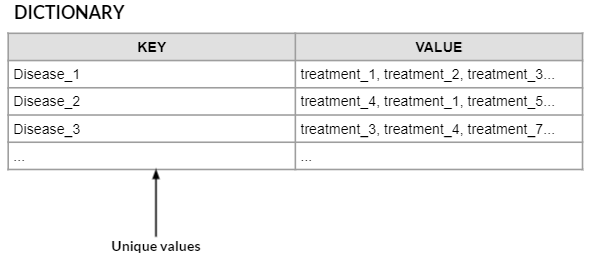

In [189]:

disease_treatment={}
#print(len(Y_pred))
for i in range(len(Y_pred)):
    diseases=[]
    treatments=[]
    disease=""
    treatment=""
    pred_tags=Y_pred[i]
    sentence_words=test_sentences[i].split()
    prev_tag=""
    prev_treatment=""
    #print(sentence_words)
    k=0
    l=0
    for j in range(len(pred_tags)):
        pred_tag=pred_tags[j]
        if pred_tag=="D" :
            if prev_tag=="D":
                disease=disease+" "+sentence_words[j]
                diseases[k-1]=disease
            else :
                
                disease=sentence_words[j] 
                diseases.append(disease)
                k=k+1
        
        if pred_tag=="T" :
            if prev_tag=="T":
                treatment=treatment+" "+sentence_words[j]
                treatments[l-1]=treatment
            else :
                treatment=sentence_words[j]
                treatments.append(treatment)
                l=l+1
        prev_tag=pred_tag
   
    for disease in diseases:
        if disease not in disease_treatment.keys():
            disease_treatment[disease]=""
        
        if(len(treatments) !=0):
            t=disease_treatment[disease]
            for treatment in treatments:
                if treatment not in t:  
                    if t == "":
                        t=treatment
                    else :
                        t=t+","+treatment
            disease_treatment[disease]=t
            
            
    


print(disease_treatment)
          
    

{'gestational diabetes cases': '', 'preeclampsia': '', 'severe preeclampsia': '', 'asymmetric double hemiplegia': '', 'A subchorial placental hematoma': '', 'breast and/or ovarian cancer': '', 'breast cancer': 'Hormone replacement therapy,undergone subcutaneous mastectomy', 'ovarian cancer': '', 'prostate cancer': 'radical prostatectomy and iodine 125 interstitial radiotherapy', 'mutated prostate cancer': '', 'hereditary prostate cancer': '', 'hereditary retinoblastoma': 'radiotherapy', "'spontaneous ' disease )": '', 'epilepsy': '', 'myocardial infarction': 'mg aspirin , 3 mg warfarin with 80 mg aspirin , or 1 mg warfarin with 80 mg aspirin', 'unstable angina or non-Q-wave myocardial infarction': 'roxithromycin', 'coronary-artery disease': '', 'early-stage cervical carcinoma': '', 'colon tumors': '', 'advanced disease': '', 'cerebral palsy': 'Hyperbaric oxygen therapy', 'severe pain': '', 'pain': '', 'myofascial trigger point pain': '', 'infections': '', 'primary pulmonary hypertensio

In [192]:
print(len(disease_treatment))

320


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [190]:
d = list(disease_treatment.keys())
index = 94
print(d[index]) # disease
print(disease_treatment.get(d[index])) # treatment list

piglet influenza



In [191]:
print(disease_treatment["hereditary retinoblastoma"])

radiotherapy


In [202]:
for i in range(len(train_sentences)):
    if("gestational diabetes case") in train_sentences[i] :
        print("line: ",i, train_sentences[i])
        print("line: ",i, train_labels[i])

line:  18 We conclude that to reduce the rate of macrosomic infants in gestational diabetes cases , good glycemic control should be initiated before 34 completed gestational weeks
line:  18 O O O O O O O O D D D D D D O T T T O O O O O O O O


In [205]:
print(disease_treatment["gestational diabetes cases"])

In [172]:
print(test_sentences[707])
print(test_labels[93])

Radiotherapy of soft tissue sarcomas
O O O O O O O O O O O O
